In [1]:
# !curl http://www.statmt.org/europarl/v7/europarl.tgz --output /content/europarl.tgz

In [2]:
import pandas as pd
import numpy as np

import os,sys
import re, string

import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns 

from typing import Dict
from dataclasses import dataclass

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
def process_files(temp_path,files):
  res = pd.DataFrame(columns=["text"])
  for file in tqdm.notebook.tqdm(files[:100]):
    
    try:
      df = pd.read_csv(os.path.join(temp_path,file), sep='\n', )
    except:
      print("skipping file : ",file)
      continue
    df.columns = ['text']
    df.dropna(inplace=True)
    df.drop(df[df['text'].str.contains('>')].index, inplace = True)
    df.drop(df[df['text'].str.contains('<')].index, inplace = True)
    res = pd.concat([res,df])

  return res
  
def get_dataset(path:str):
  langs = os.listdir(path)
  raw = pd.DataFrame(columns=["text","lang"])
  for lang in langs:
    print(lang)
    temp_path = os.path.join(path,lang)
    files = os.listdir(temp_path)
    df = process_files(temp_path,files)
    df['lang'] = [lang]*len(df)
    raw = pd.concat([raw,df])
    print(f"Extracted lang data for {lang} \nNew data points found {len(df)} total {len(raw)}")
    # print(raw.lang.value_counts())
  return raw

def pre_process(txt:str):
  regex = re.compile('[%s]' % re.escape(string.punctuation))
  txt = regex.sub(' ', txt)
  txt = re.sub(r'[0-9]+', '', txt)
  txt = " ".join(txt.split())
  return txt

In [6]:
PATH = './drive/MyDrive/dataset_havells/'
# PATH = './drive/MyDrive/testing/'
dataset = get_dataset(path=PATH)
dataset['text'] = dataset['text'].apply(pre_process)
dataset.head()

es



Extracted lang data for es 
New data points found 3502 total 3502
fr


skipping file :  ep-11-03-24-006-06.txt

Extracted lang data for fr 
New data points found 3610 total 7112
en



Extracted lang data for en 
New data points found 4993 total 12105


,text,lang
0,Posibilidad de explotar fuentes alternativas d...,es
2,El siguiente punto es la declaración de la Com...,es
4,Señora Presidenta Señorías este punto del orde...,es
6,Asimismo tenemos que considerar cómo se deben ...,es
8,En la actualidad existe un auge en las ventas ...,es


# Model By Design

In [7]:
@dataclass
class Cfg:
  in_len:int
  out_len:int
  device:str = 'cpu'
  epoch:int = 100
  lr:int = 0.001

In [8]:
class Model(nn.Module):
  def __init__(self, cfg:Cfg):
    super().__init__()
    self.cfg = cfg

    self.fc1 = nn.Linear(cfg.in_len, 500)
    self.fc2 = nn.Linear(500, 300)
    self.fc3 = nn.Linear(300, cfg.out_len)
    self.batchnorm1 = nn.BatchNorm1d(500)
    self.batchnorm2 = nn.BatchNorm1d(300)
    print(f"Model initialized, \n Config details -> {cfg} \n")

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.fc2(x))
    x = self.batchnorm2(x)
    # x = F.softmax(self.fc3(x))
    x = self.fc3(x)
    return x

In [9]:
def _get_accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [10]:
def show_results(res_):
        fig, ax = plt.subplots(
            nrows=1, ncols=2,
            figsize=(15, 9),
        )
        sns.lineplot(
            x=[i for i in range(len(res_["loss_li"]))], y=np.array(res_["loss_li"]), ax=ax[0]
        )
        ax[0].legend(["Loss"], loc="center right")
        sns.lineplot(
            x=[i for i in range(len(res_["loss_li"])) if i % 10 == 0],
            y=res_["accuracy_test"],
            ax=ax[1],
        )
        sns.lineplot(
            x=[i for i in range(len(res_["loss_li"]))], y=res_["accuracy_train"], ax=ax[1]
        )
        ax[1].legend(["Test Accuracy", "Train Accuracy"], loc="center right")
        # plt.show()

# Training loop

In [11]:
def train_model(model, X_train, X_test, y_train, y_test):
    print("criteria :  CrossEntropyLoss \n","Model information : \n",model)
    criterian = nn.CrossEntropyLoss()
    config = model.cfg
    device = torch.device(config.device)
    print("Running on ",config.device)

    model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=1e-3)

    epochs = config.epoch
    loss_li = []
    accuracy_test = []
    accuracy_train = []
    for i in tqdm.notebook.tqdm(range(epochs)):

        model.train()
        X_train, y_train = X_train.to(device), y_train.to(device)
        output = model.forward(X_train)
        # print(output.shape, np.argmax(output.detach().numpy()))
        loss = criterian(output, y_train)
        
        loss_li.append(loss.cpu().detach().numpy())

        acc = _get_accuracy(output, y_train)
        accuracy_train.append(acc.cpu().detach().numpy().tolist())

        optim.zero_grad()
        loss.backward()
        optim.step()

        if i % 10 == 0:
          with torch.no_grad():
            model.eval()
            X_test, y_test = X_test.to(device), y_test.to(device)
            pred = model(X_test)
            acc = _get_accuracy(pred,y_test)
            # print(f"At epoch : {i}  loss is : {loss}   Accuracy : {acc*100} %")
            accuracy_test.append(acc.cpu().detach().numpy().tolist())

    logs = {
        "loss_li": loss_li,
        "accuracy_test": accuracy_test,
        "accuracy_train": accuracy_train,
    }

    show_results(logs)
    
    return model,logs

# Generate Vectors

In [12]:
def _make_split(X,y, val=False, test_size=0.2, random_state=42, shuffle=True):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    if val:
      X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=random_state, 
    )

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.values)
    y_test = torch.LongTensor(y_test.values)


    # y_test = y_test.reshape(-1, 1)
    # y_train = y_train.reshape(-1, 1)
    print("y_train shape : ",y_train.shape)
    print("x_train shape : ",X_train.shape)
    
    if val:    
      X_val = torch.FloatTensor(X_val)
      y_val = torch.LongTensor(y_val.values)
      print("y_val shape : ",y_val.shape)
      return (X_train, X_val, X_test, y_train, y_val, y_test)
    
    return (X_train, X_test, y_train, y_test)

In [13]:
"""the Problem of identifying the language can be done by useing binary bag of words representaion.
this method can be very effective in solving this problem, in addition its easy to understand 
and convay to people who are new to the space of nlp"""
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(dataset['text'].values)
X.shape

(12105, 37014)

In [14]:
encoder = {k:v for v,k in enumerate(dataset.lang.unique())}
decoder = {v:k for v,k in enumerate(dataset.lang.unique())}
# print(encoder)
y = dataset['lang'].map(encoder)
assert all(y.value_counts().values == dataset.lang.value_counts().values), "please check the encoder"
y.shape

(12105,)

In [15]:
# X_train, X_test, y_train, y_test = _make_split(X.todense(), y, test_size=0.2, random_state=42, shuffle = True)

In [16]:
(X_train, X_val, X_test, y_train, y_val, y_test) = _make_split(X.todense(), y, val = True, test_size=0.2, random_state=42)

y_train shape :  torch.Size([8715])
x_train shape :  torch.Size([8715, 37014])
y_val shape :  torch.Size([969])


# RUN

Model initialized, 
 Config details -> Cfg(in_len=37014, out_len=3, device='cuda:0', epoch=100, lr=0.001) 

criteria :  CrossEntropyLoss 
 Model information : 
 Model(
  (fc1): Linear(in_features=37014, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=3, bias=True)
  (batchnorm1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Running on  cuda:0


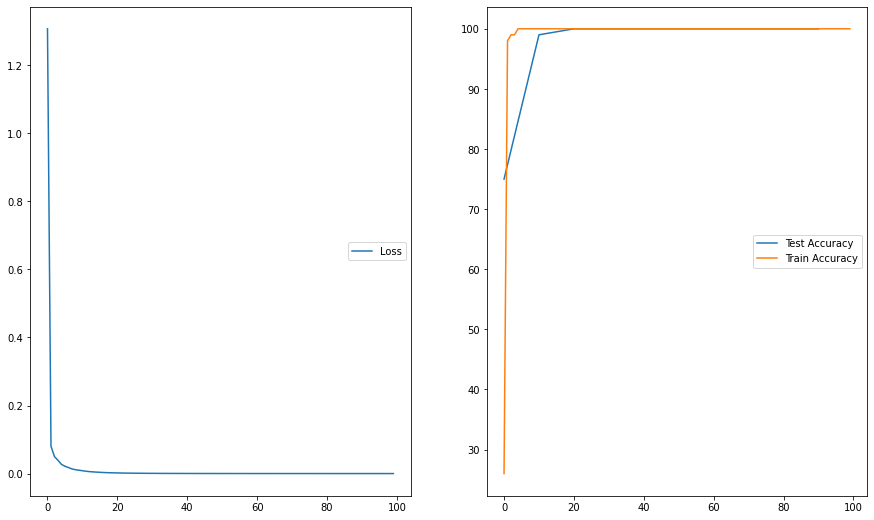

In [17]:
cfg = Cfg(in_len=len(vectorizer.get_feature_names()), out_len=3, epoch = 100,device = "cuda:0" if torch.cuda.is_available() else "cpu")
model = Model(cfg)
model,logs = train_model(model, X_train, X_val, y_train, y_val) # using Validation set

In [18]:
# !ls ./drive/MyDrive/dataset_havells
# path = './drive/MyDrive/testing/'
# os.getcwd()

## Getting test Accuracy 

In [19]:
with torch.no_grad():
  model.eval()
  model.to(torch.device('cpu'))
  y_pred = model(X_test)
  print("Acc : ",_get_accuracy(y_pred,y_test).tolist())
  _, y_pred_class = torch.max(y_pred, dim = 1)

Acc :  100.0


In [20]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_class)).rename(columns=decoder, index=decoder)
confusion_matrix_df

,es,fr,en
es,722,0,1
fr,0,717,2
en,0,0,979


In [21]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       723
           1       1.00      1.00      1.00       719
           2       1.00      1.00      1.00       979

    accuracy                           1.00      2421
   macro avg       1.00      1.00      1.00      2421
weighted avg       1.00      1.00      1.00      2421

